# UMAP evaluation

This script evaluates a previously generated UMAP representations (=embedding) based on available class information (e.g. calltype labels).

### Installing and loading libraries

In [2]:
import os
import pandas as pd
import sys
import numpy as np
from pandas.core.common import flatten
import pickle
import umap
from pathlib import Path
import datetime
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import librosa.display
from scipy.spatial.distance import pdist, squareform
from IPython.display import Image

In [3]:
from plot_functions import umap_2Dplot, mara_3Dplot, plotly_viz
from preprocessing_functions import pad_spectro, calc_zscore, preprocess_spec_numba, create_padded_data

### Setting constants

Setting project, input and output folders.

In [4]:
wd = os.getcwd()

DATA = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed")
FIGURES = os.path.join(os.path.sep, str(Path(wd).parents[0]), "reports", "figures")

DF_DICT = {}
for dftype in ['full', 'reduced', 'balanced']:
    DF_DICT[dftype] = os.path.join(os.path.sep, DATA, "df_focal_"+dftype+".pkl")
    
OVERWRITE_FIGURES = True # if true, overwrite existing figures

### Load dataset and embedding

In [5]:
#dftype='full'
dftype='reduced'
#dftype='balanced'

spec_df = pd.read_pickle(DF_DICT[dftype])
labels = spec_df.call_lable.values
spec_df.shape

(6428, 34)

In [6]:
#embedding_filename = os.path.join(os.path.sep, DATA,'basic_UMAP_3D_'+dftype+'_default_params.csv')
#embedding = np.loadtxt(embedding_filename, delimiter=";")

embedding = np.loadtxt(os.path.join(os.path.sep, DATA,'basic_UMAP_3D_reduced_default_params.csv'), delimiter=";")


## Visualization

In [7]:
pal="Set2"

### 3D Plot

#### Matplotlib 

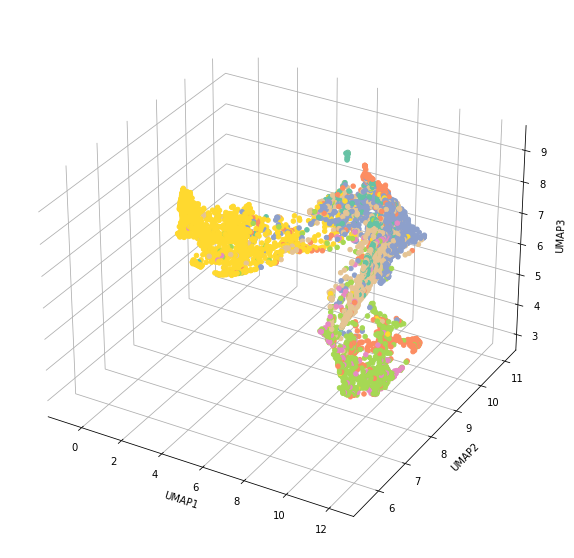

In [8]:
mara_3Dplot(embedding[:,0],
            embedding[:,1],
            embedding[:,2],
            labels,
            pal,
            outname=None,
            showlegend=False)

# Embedding evaluation

Evaluate the embedding based on calltype labels of nearest neighbors.

In [9]:
from evaluation_functions import nn, sil

In [10]:
# produce nearest neighbor statistics
nn_stats = nn(embedding, np.asarray(labels), k=5)

## Calculate nearest neighbor metrics

In [14]:
print("Log final metric (unweighted):",nn_stats.get_S())
print("Abs final metric (unweighted):",nn_stats.get_Snorm())

print(nn_stats.knn_accuracy())

Log final metric (unweighted): 61.34501086440152
Abs final metric (unweighted): 2.325701943362355
[46.13333333 69.45736434 82.80297901  9.14634146 77.20685112 94.66019417
 59.44540728]


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/heatS_UMAP_reduced.png


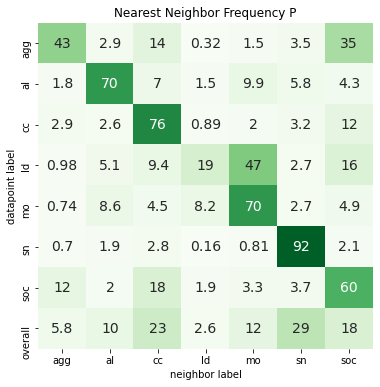

In [12]:
if OVERWRITE_FIGURES:
    outname = os.path.join(os.path.sep, FIGURES, 'heatS_UMAP_'+dftype+'.png')
else:
    outname=None

print(outname)
nn_stats.plot_heat_S(outname=outname)

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/heatSnorm_UMAP_reduced.png


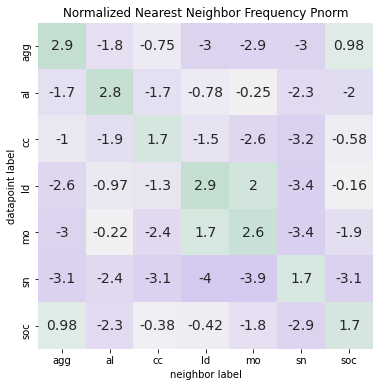

In [13]:
if OVERWRITE_FIGURES:
    outname = os.path.join(os.path.sep, FIGURES, 'heatSnorm_UMAP_'+dftype+'.png')
else:
    outname=None

print(outname)
nn_stats.plot_heat_Snorm(outname=outname)

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/heatfold_UMAP_reduced.png


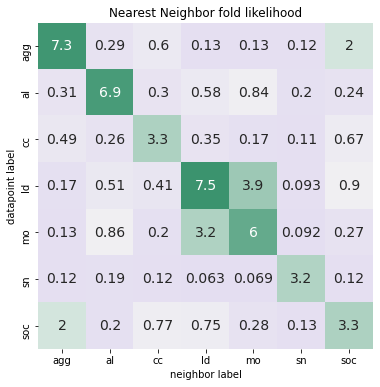

In [13]:
if OVERWRITE_FIGURES:
    outname = os.path.join(os.path.sep, FIGURES, 'heatfold_UMAP_'+dftype+'.png')
else:
    outname=None

print(outname)
nn_stats.plot_heat_fold(outname=outname)

# Plot within vs. outside distances

In [14]:
from evaluation_functions import plot_within_without

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/distanceswithinwithout_reduced.png


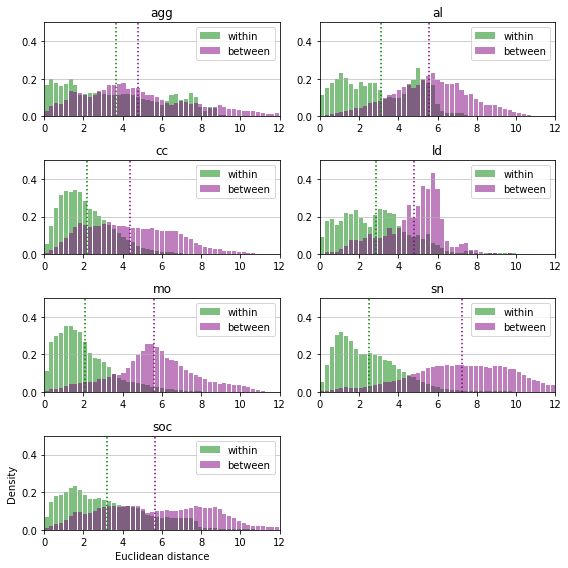

In [15]:
if OVERWRITE_FIGURES:
    outname = os.path.join(os.path.sep, FIGURES,"distanceswithinwithout_"+dftype+".png")
else:
    outname=None

print(outname)
plot_within_without(embedding=embedding, labels=labels, outname=outname)

## Silhouette Plot

In [15]:
sil_stats = sil(embedding, labels)

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/silplot_UMAP_reduced.png


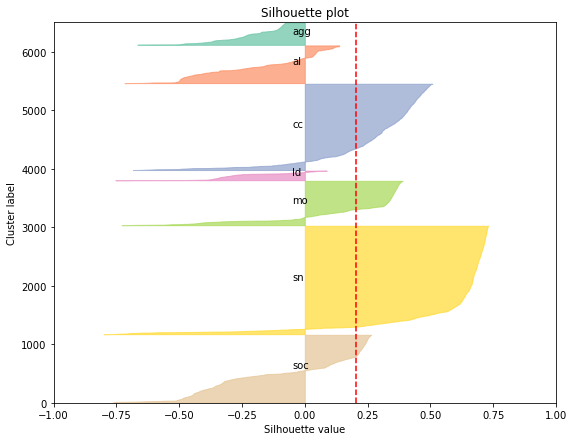

In [16]:
if OVERWRITE_FIGURES:
    outname = os.path.join(os.path.sep, FIGURES, 'silplot_UMAP_'+dftype+'.png')
else:
    outname=None

print(outname)
sil_stats.plot_sil(outname=outname)

In [17]:
sil_stats.get_avrg_score()

0.20222915059559693

# Graph from embedding evaluation

Graph saved at  /home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/simgraph_test.png


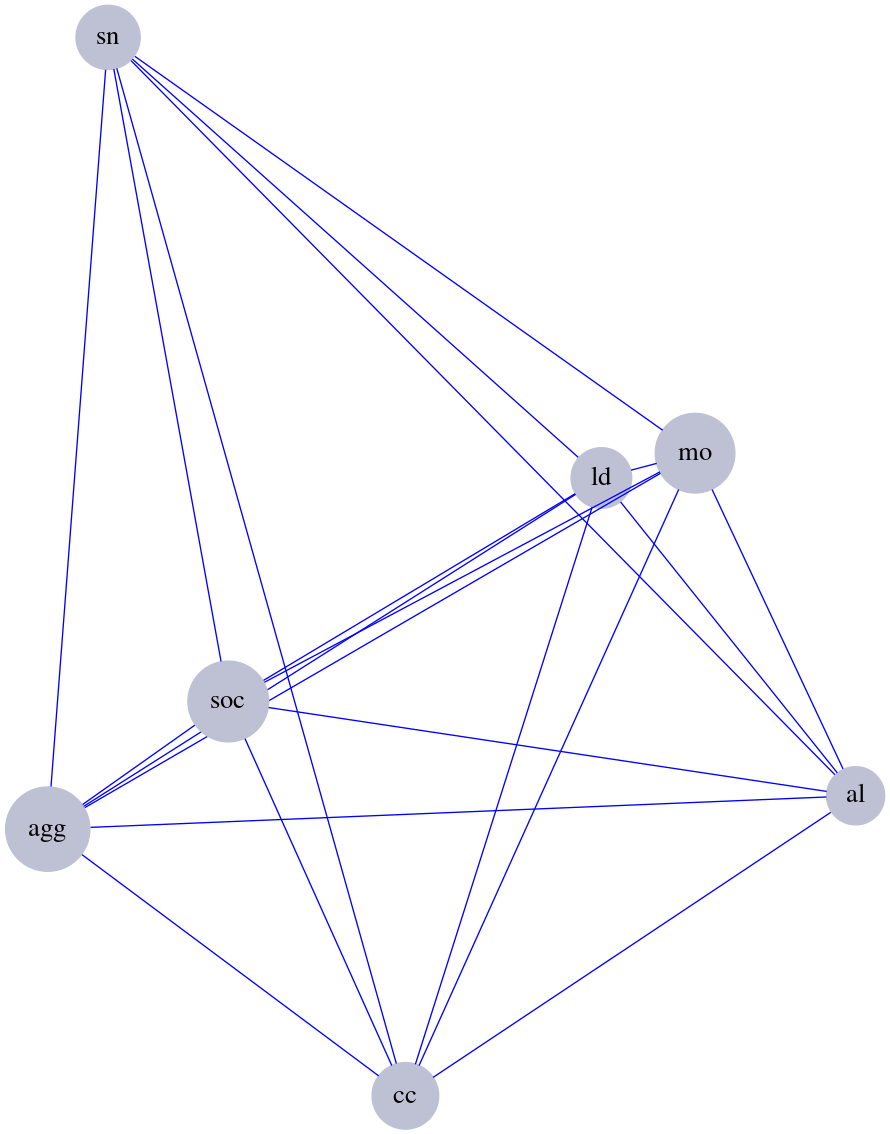

In [18]:
if OVERWRITE_FIGURES:
    outname = os.path.join(os.path.sep,FIGURES,'simgraph_test.png')
else:
    outname=None

G = nn_stats.draw_simgraph(outname)
Image(G.draw(format='png',prog='neato'), width=400, height=600)

Resource: https://en.it1352.com/article/d096c1eadbb84c19b038eb9648153346.html

# Visualize example nearest neighbors

In [19]:
import random
import scipy
from sklearn.neighbors import NearestNeighbors

In [20]:
knn=5
# Find k nearest neighbors
nbrs = NearestNeighbors(metric='euclidean',n_neighbors=knn+1, algorithm='brute').fit(embedding)
distances, indices = nbrs.kneighbors(embedding)

# need to remove the first neighbor, because that is the datapoint itself
indices = indices[:,1:]  
distances = distances[:,1:]

In [21]:
N_MELS = 40 # --> number of mel bins (usually 20-40)
            # The frequency bins are transformed to this number of logarithmically spaced mel bins.
FFT_WIN = 0.03 # --> length of audio chunk when applying STFT in seconds
               # FFT_WIN * samplerate = number of audio datapoints that go in one fft (=n_fft)
FFT_HOP = FFT_WIN/8 # --> hop_length in seconds
WINDOW = 'hann' 
FMIN = 0 
FMAX = 4000 

In [22]:
calltypes = sorted(list(set(spec_df['call_lable'])))
labels = spec_df.call_lable.values
#names = spec_df.Name.values

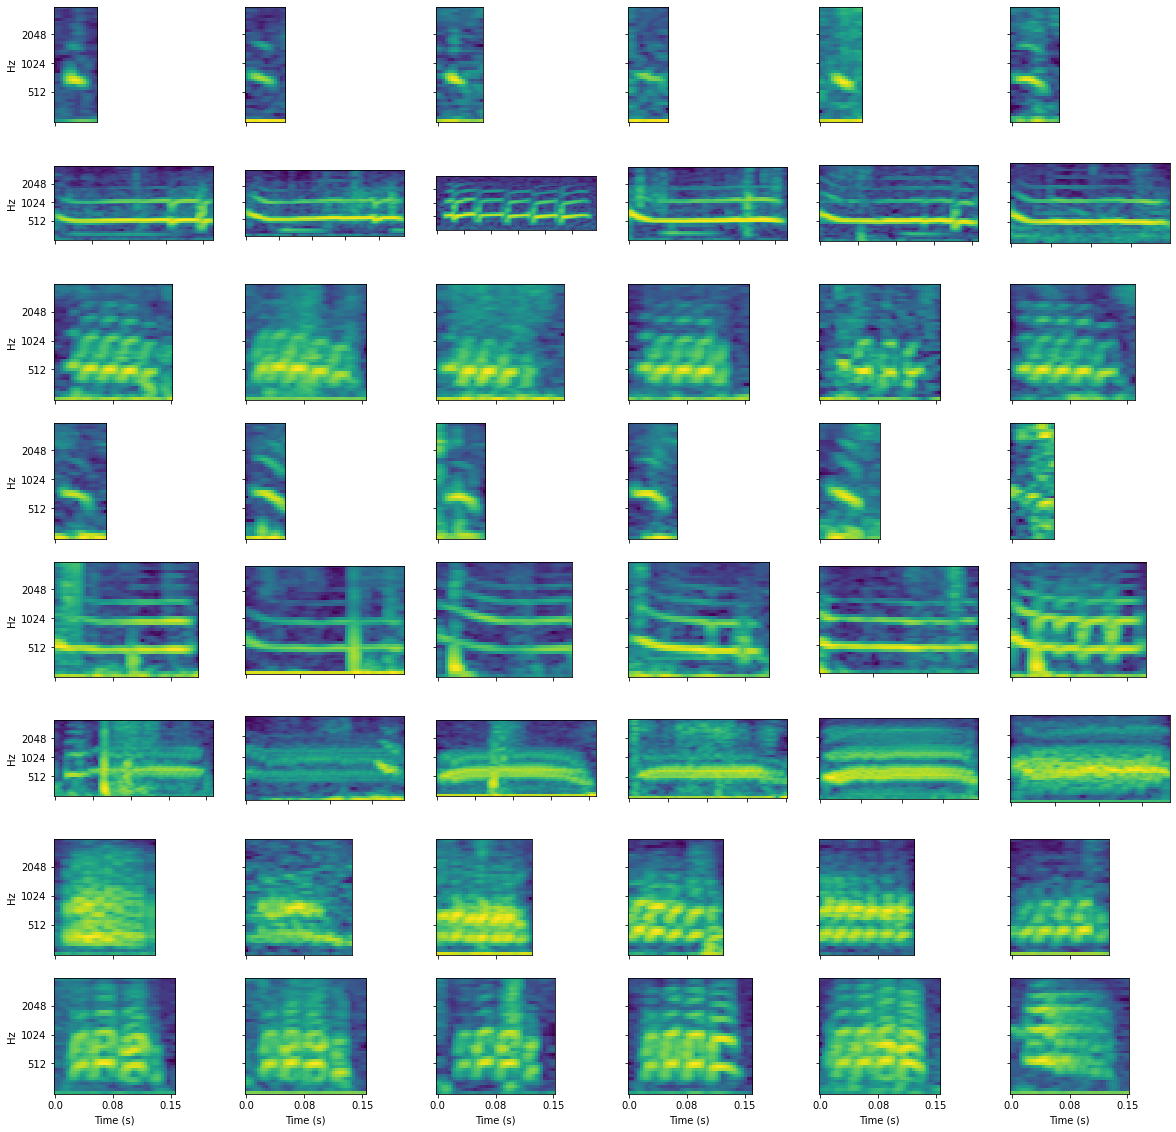

In [23]:
# Randomly choose 10 calls and plot their 4 nearest neighbors

n_examples = 8
major_tick_interval = 20
f_to_s = 0.00375
rotate_x = 0

fig = plt.figure(figsize=(20,20))
fig_name = 'NN_viz.png'
k=1

# randomly choose
random.seed(1)
example_indices = random.sample(list(range(embedding.shape[0])), n_examples)
freq_label_list = ['512', '1024', '2048']

            

for i,ind in enumerate(example_indices):
    
    # Plot the random example spectrogram
    
    img_of_interest = spec_df.iloc[ind,:].spectrograms
    embedding_of_interest = embedding[ind,:]
    plt.subplot(n_examples, knn+1, k)
    
    # Align specs to left
    ax = plt.gca()
    ax.set_anchor('W')
    #sr = spec_df.iloc[ind,:].samplerate_hz
    #librosa.display.specshow(img_of_interest,sr=SR, hop_length=int(FFT_HOP * SR) , fmin=FMIN, fmax=FMAX, y_axis='mel', x_axis='s',cmap='viridis')
    
    plt.imshow(img_of_interest, interpolation='nearest', origin='lower', aspect='equal')  
    
    # Set axis ticks and labels
    
    major_xticks = np.arange(0,img_of_interest.shape[1], major_tick_interval) # set major ticks in 0.5s steps
    major_xtick_labels = ["" for x in major_xticks] 
        
    major_yticks = [10,20,30]
    major_ytick_labels = freq_label_list
    
    # If lowest row, add x tick labels
    if i==(n_examples-1):
        major_xtick_labels = [round(x*f_to_s,2) for x in major_xticks]
        plt.xlabel('Time (s)')
    
    plt.ylabel('Hz')
    plt.xticks(major_xticks, major_xtick_labels, rotation=rotate_x)
    plt.yticks(major_yticks, major_ytick_labels,)  
    
    k=k+1

    nearest_neighbors = indices[ind]
    for neighbor in nearest_neighbors:

        neighbor_embedding = embedding[neighbor,:]
        dist_to_original = scipy.spatial.distance.euclidean(embedding_of_interest, neighbor_embedding)
        neighbor_img = spec_df.iloc[neighbor,:].spectrograms
        
        plt.subplot(n_examples, knn+1, k)
        #sr = spec_df.iloc[neighbor,:].samplerate_hz
        #librosa.display.specshow(neighbor_img,sr=sr, hop_length=int(FFT_HOP * sr) , fmin=FMIN, fmax=FMAX, y_axis='mel', x_axis='s',cmap='viridis')        
        plt.imshow(neighbor_img, interpolation='nearest', origin='lower', aspect='equal') 
        
        # Align specs to the left
        ax = plt.gca()
        ax.set_anchor('W')
        
        major_xticks = np.arange(0,neighbor_img.shape[1], major_tick_interval) # set major ticks in 0.5s steps
        major_xtick_labels = ["" for x in major_xticks] 
        
        major_yticks = [10,20,30]
        major_ytick_labels = ["" for x in major_yticks]
        
        
        if k>=(n_examples*(knn+1)-knn):
            major_xtick_labels = [round(x*f_to_s,2) for x in major_xticks]
            plt.xlabel('Time (s)')
        
        plt.yticks(major_yticks, major_ytick_labels)
        plt.xticks(major_xticks, major_xtick_labels, rotation=rotate_x)  
    
    
        k=k+1

plt.savefig(os.path.join(os.path.sep,FIGURES,fig_name), facecolor="white")

In [38]:
#seconds = librosa.frames_to_time(np.arange(0,neighbor_img.shape[1],1),sr=sr, hop_length=int(FFT_HOP * sr))
#frames = np.arange(0,neighbor_img.shape[1],1)

## EXTRA: How many dimensions?

Evaluate, how many dimensions are best for the embedding.

51.887140499337725
59.20156316165863
61.34501086440152
62.50871575698655
63.198600384121164
62.78151987750739
62.678314629396816
62.23012636254172
62.39753188525293
62.82752042439547


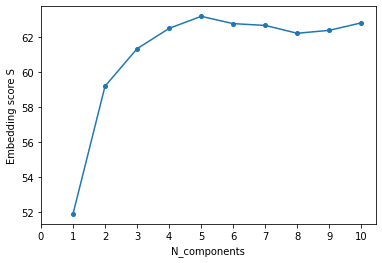

In [24]:
specs = spec_df.spectrograms.copy()
specs = [calc_zscore(x) for x in specs] 
data = create_padded_data(specs)

embeddings = {}
for n_dims in range(1,11):
    reducer = umap.UMAP(n_components = n_dims, min_dist = 0, metric='euclidean', random_state=2204)
    embeddings[n_dims] = reducer.fit_transform(data)    
    
labels = spec_df.call_lable.values
calltypes = sorted(list(set(labels)))
k=5
dims_tab = np.zeros((10,1))

for n_dims in range(1,11):
    nn_stats = nn(embeddings[n_dims], labels, k=k)
    stats_tab = nn_stats.get_statstab()
    mean_metric = np.mean(np.diagonal(stats_tab.iloc[:-1,]))
    print(mean_metric)
    dims_tab[n_dims-1,:] = mean_metric
    
x = np.arange(1,11,1)
y = dims_tab[:,0]
plt.plot(x,y, marker='o', markersize=4)
plt.xlabel("N_components")
plt.ylabel("Embedding score S")
plt.xticks(np.arange(0, 11, step=1))
plt.savefig(os.path.join(os.path.sep,FIGURES,'n_dims.png'), facecolor="white")

Note that this is different than doing UMAP with n=10 components and then selecting only the first x dimensions in UMAP space!